# Vision system for trajectory tracking of a swarm of robots
## Research project PROE
##### Project info: https://www.tec.ac.cr/node/15303/proyectos/proe-simulacion-computacional-planificacion-rutas-optimas-acceso-yo-evacuacion

### Developers:
#### Andrés Jiménez Mora
#### Kevin Morales Paz

### Description

This notebook explains the code of a computer-based vision system developed for project PROE with the goal of tracking the trajectories of several robots within a collaborative swarm. 

### Objective 

Validate the performance of a swarm of mobile robots by tracking their trajectories within a test scenario (see images
below)

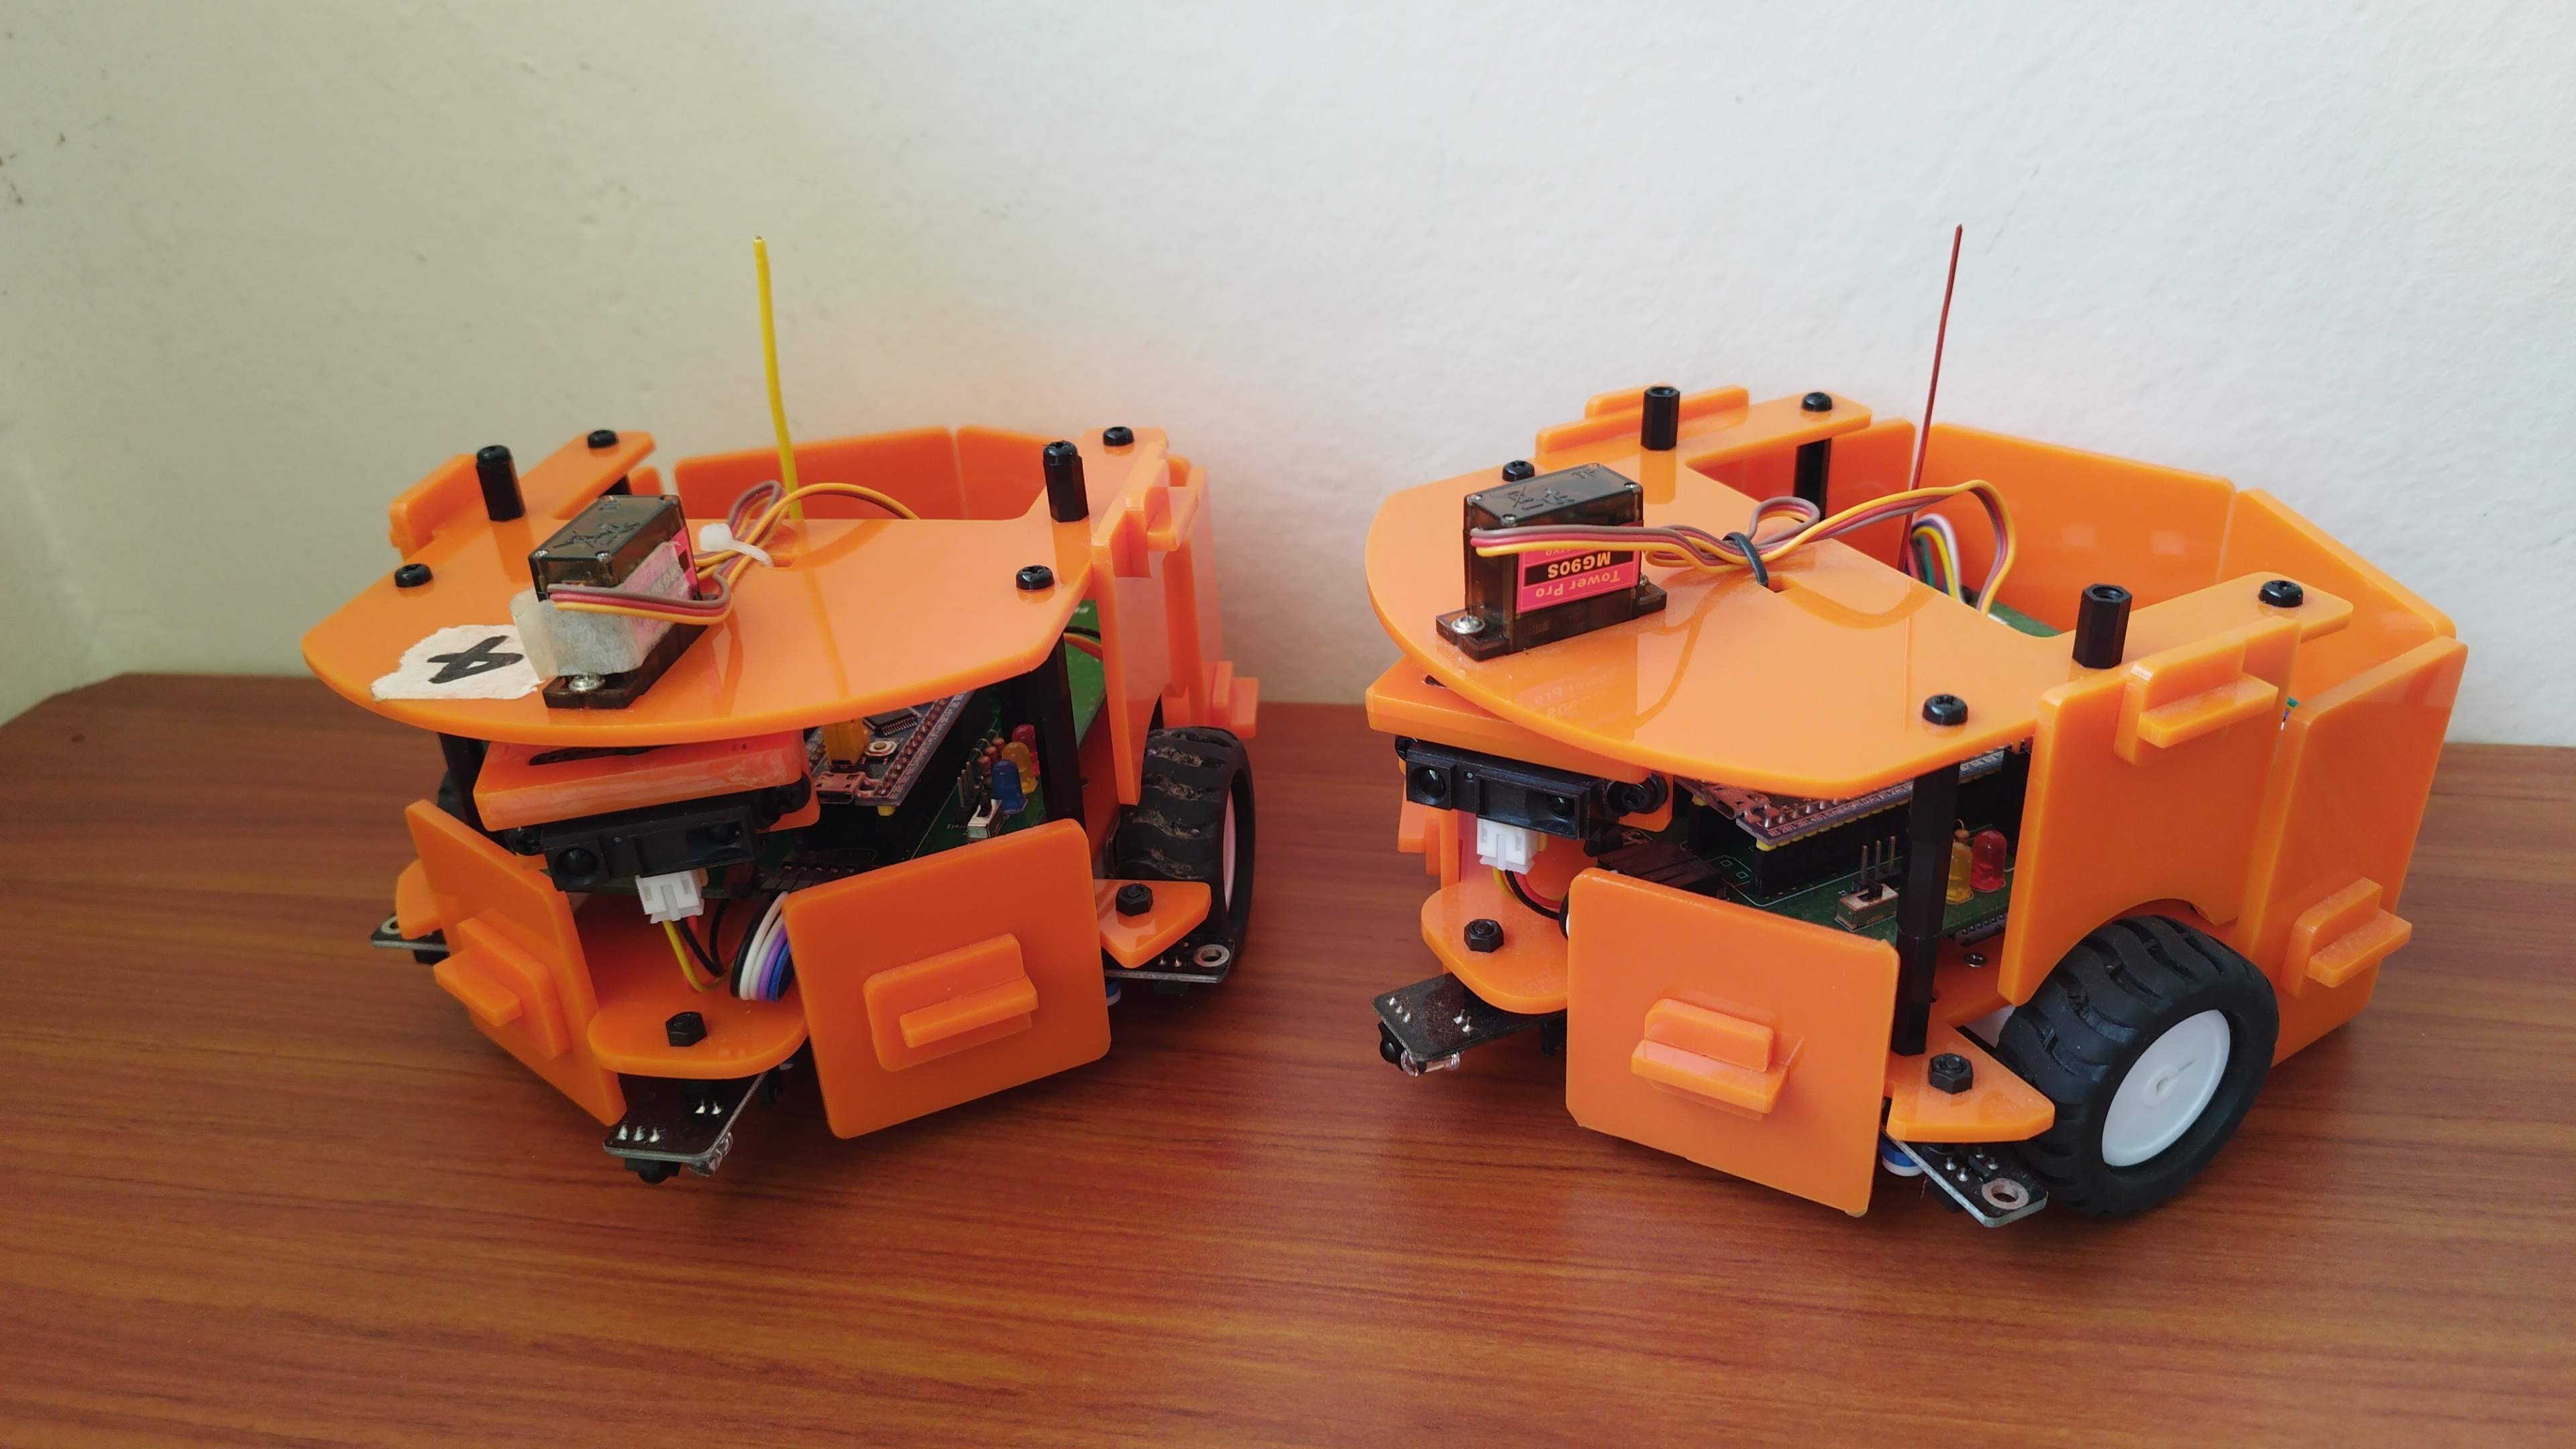

Figure 1. Low-cost robot prototype for a collaborative swarm

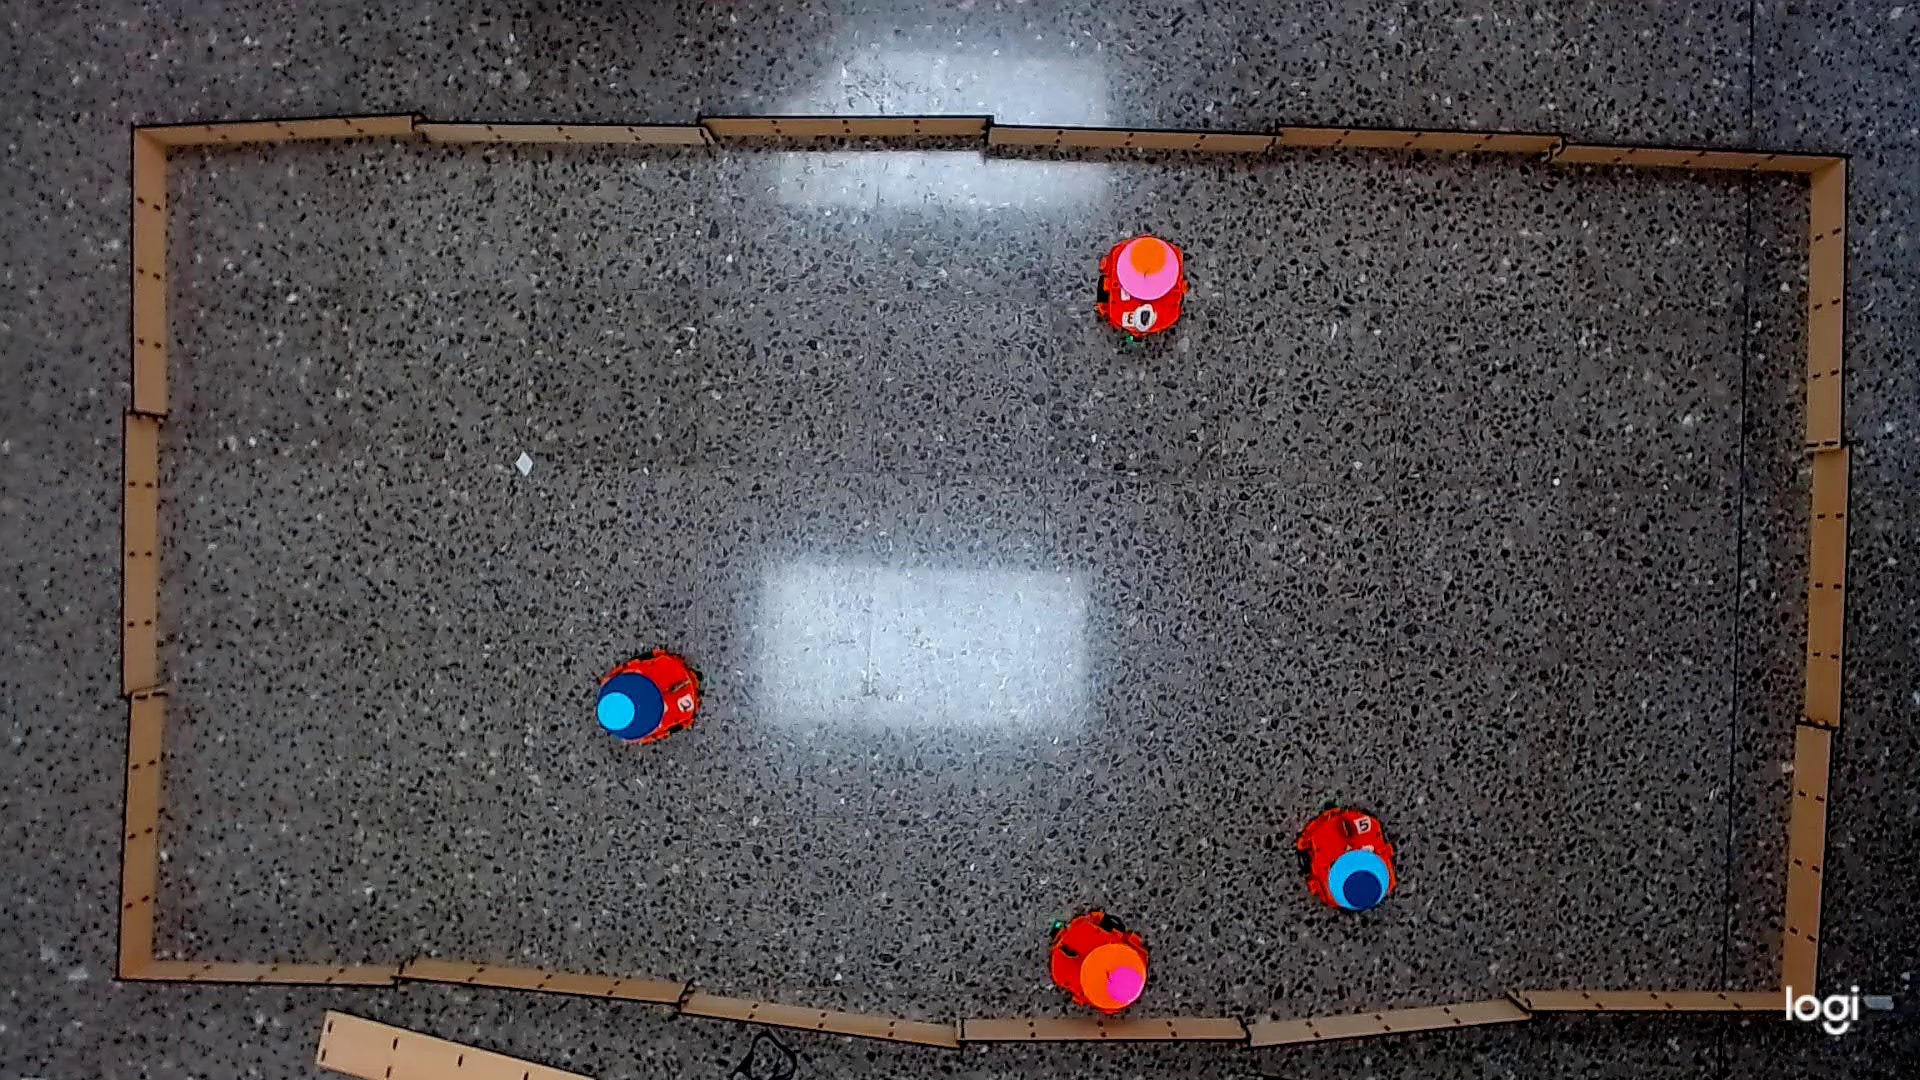

Figure 2. Testing scenario for a collaborative swarm of robots

### Solution

The vision system was based on the functions from OpenCV. The robots were differentiated from each other by using colored identifiers that were attached to them, as shown in the image above. The tests were recorded with a webcam to obtain videos for further processing. The flowchart below summarizes the robot identifications and tracking process.

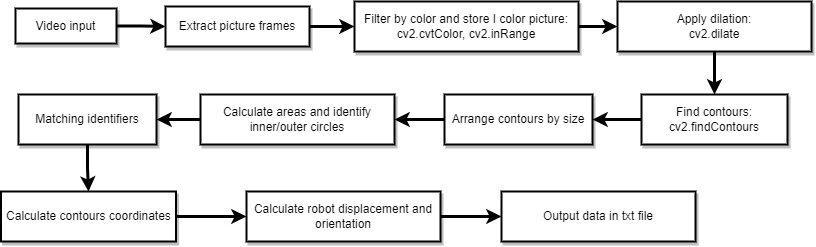

Figure 3. Flowchart for the identification process within the vision system

### Libraries and function definition

In [4]:
import cv2
import cv2 as cv
import glob
import re
import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import hsv_to_rgb
import os

#-------------------------Definición de funciones---------------------------------
#La función switch retorna el número de robot de una combinación de círculo
#grande y círculo pequeño
def switch(numColor1, numColor2):
    if numColor1==1:
        if numColor2==2:
            robot=11 #cyan-magenta
        elif numColor2==3:
            robot=1  #cyan-naranja
        elif numColor2==4:
            robot=3  #cyan-azul
        elif numColor2==5:
            robot=13 #cyan-verde
        else:
            #caso no identificado con combinaciones actuales
            robot=999
            
    elif numColor1==2:
        if numColor2==1:
            robot=12 #magenta-cyan
        elif numColor2==3:
            robot=5  #magenta-naranja
        elif numColor2==4:
            robot=9  #magenta-azul
        elif numColor2==5:
            robot=15 #magenta-verde
        else:
            #caso no identificado con combinaciones actuales
            robot=999
            
    elif numColor1==3:
        if numColor2==1:
            robot=2  #naranja-cyan
        elif numColor2==2:
            robot=6  #naranja-magenta
        elif numColor2==4:
            robot=7  #naranja-azul
        else:
            #caso no identificado con combinaciones actuales
            robot=999
    
    elif numColor1==4:
        if numColor2==1:
            robot=4  #azul-cyan
        elif numColor2==2:
            robot=10 #azul-magenta
        elif numColor2==3:
            robot=8  #azul-naranja
        else:
            #caso no identificado con combinaciones actuales
            robot=999
    
    elif numColor1==5:
        if numColor2==1:
            robot=14  #verde-cyan
        else:
            #caso no identificado con combinaciones actuales
            robot=999
    else:
        #caso no identificado
        robot=999
    return robot
    
def get_contour_areas(cont):
    #Crea una lista donde se guardarán las áreas de cada contorno
    all_areas= []
    #Recorre la lista de contornos
    for cnt in cont:
        #calcula el área de un contorno
        area= cv2.contourArea(cnt)
        #agrega el área calculada al arreglo de áreas
        all_areas.append(area)
    return all_areas

def depurar_contornos(cnts):
    #en esta lista se almacenarán los contornos pertenecientes a los círculos
    #la "d" significa depurados.
    cntsd= []
    #recorro todos los contornos encontrados
    for cnt in cnts:
        area= cv2.contourArea(cnt)
        """
        if area>=500:
            print("Area Encontrada", area)"""
        #Se encontró que el área mínima de los círculos pequeños es de 5000 unidades IMAGEN CON ZOOM
        #Se encontró que el área  de los círculos grandes es de 7000-12000 unidades aprox IMAGEN CON ZOOM
        #OJO hubo cambio del kernel de la dilatación, de 3,3 a 7,7
        #Se encontró que el área mínima de los círculos pequeños es mayor a 600 unidades aprox IMAGEN SIN ZOOM
        #Se encontró que el área  de los círculos grandes es mayor a 1200 unidades aprox IMAGEN SIN ZOOM
        #cuadradas, daremos un margeddn de error. El limite de 2500 se puso porque en magenta encontraba
        #un contorno no deseado
        #if area>=4000: #para imagen con zoom
        if area>=600 and area<4000:
            cntsd.append(cnt)    
    return cntsd

def centros_contornos(cnts, areas):
    centros= []
    #contador
    cont=0
    for s in cnts:
        #calcula los momentos
        M = cv2.moments(s)
        #Calcula el centroide
        #https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        #verifica si el contorno es de un círculo pequeño o grande:
        #if areas[cont]<=6000: #CON ZOOM
        
        #SIN ZOOM 
        if areas[cont]<=1700: 
            #circulo pequeño, se identificará con un 0
            circ=0
        else:
            #circulo grande, se identificará con un 1
            circ=1
                
        centros.append((cx, cy, circ))
        cont+=1
    return centros

def calcular_angulos(x1,x2,y1,y2):
    #solo inicialización del valor
    cita=0
    #calculo de cita respecto a la horizontal, tomando ángulos positivos en sentido horario
    """if x2==x1 or y2==y1:
        print("coordenadas iguales identificadas x, y; x2, y2", x1, y1, x2, y2)"""
    #desplazamiento vertical (da problema por ser división entre 0 en la definición de cita):
    if x2==x1:
        #subió el robot, entonces el angulo es 270 grados
        #print("coordenadas iguales identificadas x, y; x2, y2", x1, y1, x2, y2)
        if y1>y2:
            cita=1.5*math.pi
        else:
            #bajó el robot, el ángulo es 90 grados
            #print("entró")
            cita=0.5*math.pi
    elif x2<x1: #segundo y tercer cuadrante
        cita=np.arctan((y2-y1)/(x2-x1))
        cita=cita+(math.pi)
    elif x2>x1:
        if y2<y1: #cuarto cuadrante
            cita=np.arctan((y2-y1)/(x2-x1))
            cita=cita+2*(math.pi)
        else: #caso de primer cuadrante
            cita=np.arctan((y2-y1)/(x2-x1))
    else: #caso de primer cuadrante
        cita=np.arctan((y2-y1)/(x2-x1))  
    return cita

def desplazamiento(centerIm1,centerIm2, centros, robot, imagen):
    #centerIm1 e Im2 son las posiciones den las listas de centros
    desplazamientos=[]
    #extracción de las coordenadas de los centros en ambas imágenes (anterior y posterior)
    #print("Centro Imagen 1: ", centerIm1)
    #center da la posición del centro en la imagen. El 0 indica coordena x, y el 1, y.
    x1=centros[imagen][centerIm1][0]
    x2=centros[imagen+1][centerIm2][0]
    y1=centros[imagen][centerIm1][1]
    y2=centros[imagen+1][centerIm2][1]
    #print("x1,x2,y1,y2", x1, x2, y1,y2)
    distance = math.sqrt( ((x1-x2)**2)+((y1-y2)**2) )
    #se calcula el angulo según lo mostrado en la imagen "interpretacion angulos"
    #al menos un desplazamiento de 3.33mm #se puede cambiar a conveniencia
    if distance>(3*mmPixel):
        angulo=calcular_angulos(x1,x2,y1,y2)
    else:
        #si no se movió practicamente asuma ángulo 0 también
        angulo=0
    #pasa distancias a mm CON ZOOM
    #distancemm=mmPixelZ*distance
    #pasa distancias a mm SIN ZOOM
    distancemm=mmPixel*distance
    #retorna el número de imagen, el robot y cuánto se movió
    out=(imagen, robot, distancemm, angulo)
    desplazamientos.append(out)
    return desplazamientos

def calcular_desplazamiento(centrosC, centrosM, centrosV, centrosA, centrosN, numImagenes, lista_robots):
    #resolución espacial para imagen con zoom [mm/pixel]
    mmPixelZ=40/54
    #resolución espacial para imagen sin zoom [mm/pixel]
    mmPixel=40/23
    #crea la lista donde se almacenarán los desplazamientos entre 2 imágenes del
    #mismo identificador.
    #n contiene el número de imágenes
    desplazamientos=[]
    #contiene las posiciones iniciales de los robots
    posIniciales=[]
    #lista de números de robots
    Robots=[]
    
    #analiza todas las imágenes en pares: momento anterior y momento posterior, hasta n-1 imágenes
    #en el caso de solicitud de Cyan
    #buscaremos Cyan con el resto de colores:
    
    #cada peers contendrá el número de imagen, los colores pareja,
    #el centro x,y de cada contorno que es pareja. Peers devuelve
    #desde 0 parejas, hasta el número de combinaciones de un color de
    #círculo grande con el resto de colores.
    
    if (1 in lista_robots):
        #Cyan-naranja
        CNpeers=buscar_peer(1, 3, centrosC, centrosN)
        #calcula desplazamientos solo si encontró robots
        if len(CNpeers)!=0:
            #se asume el robot NO desaparece de la escena
            #k es el número de imagen
            for k in range (numImagenes-1):
                #pareja es el número de pareja en la k-ésima imagen
                for pareja in range(len(CNpeers[k])):
                    #la última posición que es 2 indica que extrae el centro del círculo grande
                    centerIm1=CNpeers[k][pareja][2]
                    #extrae el centro grande de la pareja pero en la imagen siguiente
                    centerIm2=CNpeers[k+1][pareja][2]
                    #la posición 1 indica el número de robot al que corresponde la pareja
                    robot= CNpeers[k][pareja][1]
                    """#la posición 0 indica el número de imagen
                    imagen= CMpeers[k][pareja][0]"""
                    #movimiento devuelve el #imagen, el robot y cuánto se desplazó
                    movimiento=desplazamiento(centerIm1,centerIm2, centrosC, robot, k)
                    desplazamientos.append(movimiento)
                    #si es la primera imagen
                    if movimiento[0][0]==0:
                        #retorna identificador 99 que significa inicial, #robot, coordenada x, coordenada y
                        x=centrosC[0][centerIm1][0]*mmPixel
                        y=centrosC[0][centerIm1][1]*mmPixel
                        inicial=(99, movimiento[0][1],x, y)
                        #se agrega la posicion inicial a la lista
                        posIniciales.append(inicial)
    
    if (2 in lista_Robots):
        #Naranja-cyan
        NCpeers=buscar_peer(3, 1, centrosN, centrosC)
        #calcula desplazamientos solo si encontró robots
        if len(NCpeers)!=0:
            #se asume el robot NO desaparece de la escena
            #k es el número de imagen
            for k in range (numImagenes-1):
                #pareja es el número de pareja en la k-ésima imagen
                for pareja in range(len(NCpeers[k])):
                    #la última posición que es 2 indica que extrae el centro del círculo grande
                    centerIm1=NCpeers[k][pareja][2]
                    #extrae el centro grande de la pareja pero en la imagen siguiente
                    centerIm2=NCpeers[k+1][pareja][2]
                    #la posición 1 indica el número de robot al que corresponde la pareja
                    robot= NCpeers[k][pareja][1]
                    """#la posición 0 indica el número de imagen
                    imagen= CMpeers[k][pareja][0]"""
                    #movimiento devuelve el #imagen, el robot y cuánto se desplazó
                    movimiento=desplazamiento(centerIm1,centerIm2, centrosN, robot, k)
                    desplazamientos.append(movimiento)
                    #si es la primera imagen
                    if movimiento[0][0]==0:
                        #retorna identificador 99 que significa inicial, #robot, coordenada x, coordenada y
                        x=centrosC[0][centerIm1][0]*mmPixel
                        y=centrosC[0][centerIm1][1]*mmPixel
                        inicial=(99, movimiento[0][1],x, y)
                        #se agrega la posicion inicial a la lista
                        posIniciales.append(inicial)
    
    if (3 in lista_Robots):
        #Cyan-azul
        CApeers=buscar_peer(1, 4, centrosC, centrosA)
        #calcula desplazamientos solo si encontró robots
        if len(CApeers)!=0:
            #se asume el robot NO desaparece de la escena
            #k es el número de imagen
            for k in range (numImagenes-1):
                #pareja es el número de pareja en la k-ésima imagen
                for pareja in range(len(CApeers[k])):
                    #la última posición que es 2 indica que extrae el centro del círculo grande
                    centerIm1=CApeers[k][pareja][2]
                    #extrae el centro grande de la pareja pero en la imagen siguiente
                    centerIm2=CApeers[k+1][pareja][2]
                    #la posición 1 indica el número de robot al que corresponde la pareja
                    robot= CApeers[k][pareja][1]
                    """#la posición 0 indica el número de imagen
                    imagen= CMpeers[k][pareja][0]"""
                    #movimiento devuelve el #imagen, el robot y cuánto se desplazó
                    movimiento=desplazamiento(centerIm1,centerIm2, centrosC, robot, k)
                    desplazamientos.append(movimiento)
                    #si es la primera imagen
                    if movimiento[0][0]==0:
                        #retorna identificador 99 que significa inicial, #robot, coordenada x, coordenada y
                        x=centrosC[0][centerIm1][0]*mmPixel
                        y=centrosC[0][centerIm1][1]*mmPixel
                        inicial=(99, movimiento[0][1],x, y)
                        #se agrega la posicion inicial a la lista
                        posIniciales.append(inicial)
    
    if (4 in lista_Robots):
        #Azul-cyan
        ACpeers=buscar_peer(4, 1, centrosA, centrosC)
        #calcula desplazamientos solo si encontró robots
        if len(ACpeers)!=0:
            #se asume el robot NO desaparece de la escena
            #k es el número de imagen
            for k in range (numImagenes-1):
                #pareja es el número de pareja en la k-ésima imagen
                for pareja in range(len(ACpeers[k])):
                    #la última posición que es 2 indica que extrae el centro del círculo grande
                    centerIm1=ACpeers[k][pareja][2]
                    #extrae el centro grande de la pareja pero en la imagen siguiente
                    centerIm2=ACpeers[k+1][pareja][2]
                    #la posición 1 indica el número de robot al que corresponde la pareja
                    robot= ACpeers[k][pareja][1]
                    """#la posición 0 indica el número de imagen
                    imagen= CMpeers[k][pareja][0]"""
                    #movimiento devuelve el #imagen, el robot y cuánto se desplazó
                    movimiento=desplazamiento(centerIm1,centerIm2, centrosA, robot, k)
                    desplazamientos.append(movimiento)
                    #si es la primera imagen
                    if movimiento[0][0]==0:
                        #retorna identificador 99 que significa inicial, #robot, coordenada x, coordenada y
                        x=centrosA[0][centerIm1][0]*mmPixel
                        y=centrosA[0][centerIm1][1]*mmPixel
                        inicial=(99, movimiento[0][1],x, y)
                        #se agrega la posicion inicial a la lista
                        posIniciales.append(inicial)
    
    if (5 in lista_Robots):
        #Magenta-naranja
        MNpeers=buscar_peer(2, 3, centrosM, centrosN)
        #calcula desplazamientos solo si encontró robots
        if len(MNpeers)!=0:
            #se asume el robot NO desaparece de la escena
            #k es el número de imagen
            for k in range (numImagenes-1):
                #pareja es el número de pareja en la k-ésima imagen
                for pareja in range(len(MNpeers[k])):
                    #la última posición que es 2 indica que extrae el centro del círculo grande
                    centerIm1=MNpeers[k][pareja][2]
                    #extrae el centro grande de la pareja pero en la imagen siguiente
                    centerIm2=MNpeers[k+1][pareja][2]
                    #la posición 1 indica el número de robot al que corresponde la pareja
                    robot= MNpeers[k][pareja][1]
                    """#la posición 0 indica el número de imagen
                    imagen= CMpeers[k][pareja][0]"""
                    #movimiento devuelve el #imagen, el robot y cuánto se desplazó
                    movimiento=desplazamiento(centerIm1,centerIm2, centrosM, robot, k)
                    desplazamientos.append(movimiento)
                    #si es la primera imagen
                    if movimiento[0][0]==0:
                        #retorna identificador 99 que significa inicial, #robot, coordenada x, coordenada y
                        x=centrosM[0][centerIm1][0]*mmPixel
                        y=centrosM[0][centerIm1][1]*mmPixel
                        inicial=(99, movimiento[0][1],x, y)
                        #se agrega la posicion inicial a la lista
                        posIniciales.append(inicial)
    
    if (6 in lista_Robots):
        #Naranja-magenta
        NMpeers=buscar_peer(3, 2, centrosN, centrosM)
        #calcula desplazamientos solo si encontró robots
        if len(NMpeers)!=0:
            #se asume el robot NO desaparece de la escena
            #k es el número de imagen
            for k in range (numImagenes-1):
                #pareja es el número de pareja en la k-ésima imagen
                for pareja in range(len(NMpeers[k])):
                    #la última posición que es 2 indica que extrae el centro del círculo grande
                    centerIm1=NMpeers[k][pareja][2]
                    #extrae el centro grande de la pareja pero en la imagen siguiente
                    centerIm2=NMpeers[k+1][pareja][2]
                    #la posición 1 indica el número de robot al que corresponde la pareja
                    robot= NMpeers[k][pareja][1]
                    """#la posición 0 indica el número de imagen
                    imagen= CMpeers[k][pareja][0]"""
                    #movimiento devuelve el #imagen, el robot y cuánto se desplazó
                    movimiento=desplazamiento(centerIm1,centerIm2, centrosN, robot, k)
                    desplazamientos.append(movimiento)
                    #si es la primera imagen
                    if movimiento[0][0]==0:
                        #retorna identificador 99 que significa inicial, #robot, coordenada x, coordenada y
                        x=centrosN[0][centerIm1][0]*mmPixel
                        y=centrosN[0][centerIm1][1]*mmPixel
                        inicial=(99, movimiento[0][1],x, y)
                        #se agrega la posicion inicial a la lista
                        posIniciales.append(inicial)
    
    if (7 in lista_Robots):
        #Naranja-azul
        NApeers=buscar_peer(3, 4, centrosN, centrosA)
        #calcula desplazamientos solo si encontró robots
        if len(NApeers)!=0:
            #se asume el robot NO desaparece de la escena
            #k es el número de imagen
            for k in range (numImagenes-1):
                #pareja es el número de pareja en la k-ésima imagen
                for pareja in range(len(NApeers[k])):
                    #la última posición que es 2 indica que extrae el centro del círculo grande
                    centerIm1=NApeers[k][pareja][2]
                    #extrae el centro grande de la pareja pero en la imagen siguiente
                    centerIm2=NApeers[k+1][pareja][2]
                    #la posición 1 indica el número de robot al que corresponde la pareja
                    robot= NApeers[k][pareja][1]
                    """#la posición 0 indica el número de imagen
                    imagen= CMpeers[k][pareja][0]"""
                    #movimiento devuelve el #imagen, el robot y cuánto se desplazó
                    movimiento=desplazamiento(centerIm1,centerIm2, centrosN, robot, k)
                    desplazamientos.append(movimiento)
                    #si es la primera imagen
                    if movimiento[0][0]==0:
                        #retorna identificador 99 que significa inicial, #robot, coordenada x, coordenada y
                        x=centrosC[0][centerIm1][0]*mmPixel
                        y=centrosC[0][centerIm1][1]*mmPixel
                        inicial=(99, movimiento[0][1],x, y)
                        #se agrega la posicion inicial a la lista
                        posIniciales.append(inicial)
    
    if (8 in lista_Robots):
        #Azul-naranja
        ANpeers=buscar_peer(4, 3, centrosA, centrosN)
        #calcula desplazamientos solo si encontró robots
        if len(ANpeers)!=0:
            #se asume el robot NO desaparece de la escena
            #k es el número de imagen
            for k in range (numImagenes-1):
                #pareja es el número de pareja en la k-ésima imagen
                for pareja in range(len(ANpeers[k])):
                    #la última posición que es 2 indica que extrae el centro del círculo grande
                    centerIm1=ANpeers[k][pareja][2]
                    #extrae el centro grande de la pareja pero en la imagen siguiente
                    centerIm2=ANpeers[k+1][pareja][2]
                    #la posición 1 indica el número de robot al que corresponde la pareja
                    robot= ANpeers[k][pareja][1]
                    """#la posición 0 indica el número de imagen
                    imagen= CMpeers[k][pareja][0]"""
                    #movimiento devuelve el #imagen, el robot y cuánto se desplazó
                    movimiento=desplazamiento(centerIm1,centerIm2, centrosA, robot, k)
                    desplazamientos.append(movimiento)
                    #si es la primera imagen
                    if movimiento[0][0]==0:
                        #retorna identificador 99 que significa inicial, #robot, coordenada x, coordenada y
                        x=centrosC[0][centerIm1][0]*mmPixel
                        y=centrosC[0][centerIm1][1]*mmPixel
                        inicial=(99, movimiento[0][1],x, y)
                        #se agrega la posicion inicial a la lista
                        posIniciales.append(inicial)
    
    if (9 in lista_Robots):
        #Magenta-azul
        MApeers=buscar_peer(2, 4, centrosM, centrosA)
        #calcula desplazamientos solo si encontró robots
        if len(MApeers)!=0:
            #se asume el robot NO desaparece de la escena
            #k es el número de imagen
            for k in range (numImagenes-1):
                #pareja es el número de pareja en la k-ésima imagen
                for pareja in range(len(MApeers[k])):
                    #la última posición que es 2 indica que extrae el centro del círculo grande
                    centerIm1=MApeers[k][pareja][2]
                    #extrae el centro grande de la pareja pero en la imagen siguiente
                    centerIm2=MApeers[k+1][pareja][2]
                    #la posición 1 indica el número de robot al que corresponde la pareja
                    robot= MApeers[k][pareja][1]
                    """#la posición 0 indica el número de imagen
                    imagen= CMpeers[k][pareja][0]"""
                    #movimiento devuelve el #imagen, el robot y cuánto se desplazó
                    movimiento=desplazamiento(centerIm1,centerIm2, centrosM, robot, k)
                    desplazamientos.append(movimiento)
                    #si es la primera imagen
                    if movimiento[0][0]==0:
                        #retorna identificador 99 que significa inicial, #robot, coordenada x, coordenada y
                        x=centrosC[0][centerIm1][0]*mmPixel
                        y=centrosC[0][centerIm1][1]*mmPixel
                        inicial=(99, movimiento[0][1],x, y)
                        #se agrega la posicion inicial a la lista
                        posIniciales.append(inicial)
    
    if (10 in lista_Robots):
        #Azul-Magenta
        AMpeers=buscar_peer(4, 2, centrosA, centrosM)
        #calcula desplazamientos solo si encontró robots
        if len(AMpeers)!=0:
            #se asume el robot NO desaparece de la escena
            #k es el número de imagen
            for k in range (numImagenes-1):
                #pareja es el número de pareja en la k-ésima imagen
                for pareja in range(len(AMpeers[k])):
                    #la última posición que es 2 indica que extrae el centro del círculo grande
                    centerIm1=AMpeers[k][pareja][2]
                    #extrae el centro grande de la pareja pero en la imagen siguiente
                    centerIm2=AMpeers[k+1][pareja][2]
                    #la posición 1 indica el número de robot al que corresponde la pareja
                    robot= AMpeers[k][pareja][1]
                    """#la posición 0 indica el número de imagen
                    imagen= CMpeers[k][pareja][0]"""
                    #movimiento devuelve el #imagen, el robot y cuánto se desplazó
                    movimiento=desplazamiento(centerIm1,centerIm2, centrosA, robot, k)
                    desplazamientos.append(movimiento)
                    #si es la primera imagen
                    if movimiento[0][0]==0:
                        #retorna identificador 99 que significa inicial, #robot, coordenada x, coordenada y
                        x=centrosC[0][centerIm1][0]*mmPixel
                        y=centrosC[0][centerIm1][1]*mmPixel
                        inicial=(99, movimiento[0][1],x, y)
                        #se agrega la posicion inicial a la lista
                        posIniciales.append(inicial)
    
    if (11 in lista_Robots):
        #Cyan-magenta
        CMpeers=buscar_peer(1, 2, centrosC, centrosM)
        #calcula desplazamientos solo si encontró robots
        if len(CMpeers)!=0:
            #se asume el robot NO desaparece de la escena
            #k es el número de imagen
            for k in range (numImagenes-1):
                #pareja es el número de pareja en la k-ésima imagen
                for pareja in range(len(CMpeers[k])):
                    #la última posición que es 2 indica que extrae el centro del círculo grande
                    centerIm1=CMpeers[k][pareja][2]
                    #extrae el centro grande de la pareja pero en la imagen siguiente
                    centerIm2=CMpeers[k+1][pareja][2]
                    #la posición 1 indica el número de robot al que corresponde la pareja
                    robot= CMpeers[k][pareja][1]
                    """#la posición 0 indica el número de imagen
                    imagen= CMpeers[k][pareja][0]"""
                    #movimiento devuelve el #imagen, el robot y cuánto se desplazó
                    movimiento=desplazamiento(centerIm1,centerIm2, centrosC, robot, k)
                    desplazamientos.append(movimiento)
                    #si es la primera imagen
                    if movimiento[0][0]==0:
                        #retorna identificador 99 que significa inicial, #robot, coordenada x, coordenada y
                        x=centrosC[0][centerIm1][0]*mmPixel
                        y=centrosC[0][centerIm1][1]*mmPixel
                        inicial=(99, movimiento[0][1],x, y)
                        #se agrega la posicion inicial a la lista
                        posIniciales.append(inicial)
    
    if (12 in lista_Robots):
        #Magenta-cyan
        MCpeers=buscar_peer(2, 1, centrosM, centrosC)
        #calcula desplazamientos solo si encontró robots
        if len(MCpeers)!=0:
            #se asume el robot NO desaparece de la escena
            #k es el número de imagen
            for k in range (numImagenes-1):
                #pareja es el número de pareja en la k-ésima imagen
                for pareja in range(len(MCpeers[k])):
                    #la última posición que es 2 indica que extrae el centro del círculo grande
                    centerIm1=MCpeers[k][pareja][2]
                    #extrae el centro grande de la pareja pero en la imagen siguiente
                    centerIm2=MCpeers[k+1][pareja][2]
                    #la posición 1 indica el número de robot al que corresponde la pareja
                    robot= MCpeers[k][pareja][1]
                    """#la posición 0 indica el número de imagen
                    imagen= CMpeers[k][pareja][0]"""
                    #movimiento devuelve el #imagen, el robot y cuánto se desplazó
                    movimiento=desplazamiento(centerIm1,centerIm2, centrosM, robot, k)
                    desplazamientos.append(movimiento)
                    #si es la primera imagen
                    if movimiento[0][0]==0:
                        #retorna identificador 99 que significa inicial, #robot, coordenada x, coordenada y
                        x=centrosC[0][centerIm1][0]*mmPixel
                        y=centrosC[0][centerIm1][1]*mmPixel
                        inicial=(99, movimiento[0][1],x, y)
                        #se agrega la posicion inicial a la lista
                        posIniciales.append(inicial)
                        
    if (13 in lista_Robots):
        #Cyan-verde
        CVpeers=buscar_peer(1, 5, centrosC, centrosV)
        #calcula desplazamientos solo si encontró robots
        if len(CVpeers)!=0:
            #se asume el robot NO desaparece de la escena
            #k es el número de imagen
            for k in range (numImagenes-1):
                #pareja es el número de pareja en la k-ésima imagen
                for pareja in range(len(CVpeers[k])):
                    #la última posición que es 2 indica que extrae el centro del círculo grande
                    centerIm1=CVpeers[k][pareja][2]
                    #extrae el centro grande de la pareja pero en la imagen siguiente
                    centerIm2=CVpeers[k+1][pareja][2]
                    #la posición 1 indica el número de robot al que corresponde la pareja
                    robot= CVpeers[k][pareja][1]
                    """#la posición 0 indica el número de imagen
                    imagen= CMpeers[k][pareja][0]"""
                    #movimiento devuelve el #imagen, el robot y cuánto se desplazó
                    movimiento=desplazamiento(centerIm1,centerIm2, centrosC, robot, k)
                    desplazamientos.append(movimiento)
                    #si es la primera imagen
                    if movimiento[0][0]==0:
                        #retorna identificador 99 que significa inicial, #robot, coordenada x, coordenada y
                        x=centrosC[0][centerIm1][0]*mmPixel
                        y=centrosC[0][centerIm1][1]*mmPixel
                        inicial=(99, movimiento[0][1],x, y)
                        #se agrega la posicion inicial a la lista
                        posIniciales.append(inicial)
    
    if (14 in lista_Robots):
        #Verde-Cyan
        VCpeers=buscar_peer(5, 1, centrosV, centrosC)
        #calcula desplazamientos solo si encontró robots
        if len(VCpeers)!=0:
            #se asume el robot NO desaparece de la escena
            #k es el número de imagen
            for k in range (numImagenes-1):
                #pareja es el número de pareja en la k-ésima imagen
                for pareja in range(len(CVpeers[k])):
                    #la última posición que es 2 indica que extrae el centro del círculo grande
                    centerIm1=VCpeers[k][pareja][2]
                    #extrae el centro grande de la pareja pero en la imagen siguiente
                    centerIm2=VCpeers[k+1][pareja][2]
                    #la posición 1 indica el número de robot al que corresponde la pareja
                    robot= VCpeers[k][pareja][1]
                    """#la posición 0 indica el número de imagen
                    imagen= CMpeers[k][pareja][0]"""
                    #movimiento devuelve el #imagen, el robot y cuánto se desplazó
                    movimiento=desplazamiento(centerIm1,centerIm2, centrosV, robot, k)
                    desplazamientos.append(movimiento)
                    #si es la primera imagen
                    if movimiento[0][0]==0:
                        #retorna identificador 99 que significa inicial, #robot, coordenada x, coordenada y
                        x=centrosV[0][centerIm1][0]*mmPixel
                        y=centrosV[0][centerIm1][1]*mmPixel
                        inicial=(99, movimiento[0][1],x, y)
                        #se agrega la posicion inicial a la lista
                        posIniciales.append(inicial)

    if (15 in lista_Robots):
        #Magenta-Verde    
        MVpeers=buscar_peer(2, 5, centrosM, centrosV)
        #calcula desplazamientos solo si encontró robots
        if len(MVpeers)!=0:
            #se asume el robot NO desaparece de la escena
            #k es el número de imagen
            for k in range (numImagenes-1):
                #pareja es el número de pareja en la k-ésima imagen
                for pareja in range(len(MVpeers[k])):
                    #la última posición que es 2 indica que extrae el centro del círculo grande
                    centerIm1=MVpeers[k][pareja][2]
                    #extrae el centro grande de la pareja pero en la imagen siguiente
                    centerIm2=MVpeers[k+1][pareja][2]
                    #la posición 1 indica el número de robot al que corresponde la pareja
                    robot= MVpeers[k][pareja][1]
                    """#la posición 0 indica el número de imagen
                    imagen= CMpeers[k][pareja][0]"""
                    #movimiento devuelve el #imagen, el robot y cuánto se desplazó
                    movimiento=desplazamiento(centerIm1,centerIm2, centrosM, robot, k)
                    desplazamientos.append(movimiento)
                    #si es la primera imagen
                    if movimiento[0][0]==0:
                        #retorna identificador 99 que significa inicial, #robot, coordenada x, coordenada y
                        x=centrosM[0][centerIm1][0]*mmPixel
                        y=centrosM[0][centerIm1][1]*mmPixel
                        inicial=(99, movimiento[0][1],x, y)
                        #se agrega la posicion inicial a la lista
                        posIniciales.append(inicial)
    
    return desplazamientos, posIniciales

def escribir_txt(nombretxt,desplazamientos, posIniciales):
    with open(nombretxt, 'w') as output:
        output.write("99 = es una posición inicial; robot; coordenada x en mm; coordenada y en mm; ángulo respecto a la horizontal"+ '\n')
        for pos in posIniciales:
            identificador=pos[0]
            robot=pos[1]
            x=pos[2]
            y=pos[3]
            #no se ocupa angulo porque se tiene la posicion inicial
            output.write(str(identificador) + ";"+str(robot)+ ";"+ str(x)+";"+  str(y)+ '\n')
        output.write("Desplazamientos: #imagen; robot; desplazamiento; ángulo"+ '\n')
        for d in desplazamientos:
            #print("desplazamiento d: ", d)
            imagen=d[0][0]
            robot=d[0][1]
            desplazamiento=d[0][2]
            angulo=d[0][3]
            output.write(str(imagen) + ";"+str(robot)+ ";"+ str(desplazamiento)+";"+ str(angulo)+ '\n')
        print('\n')
        print("Archivo creado")
        
def buscar_peer(numColor1, numColor2, centrosC1, centrosC2):
    #la lista de peers contendrá los colores que son pareja (su identificador), y la posición
    #de cada círculo en la lista de centros.
    peers=[]
    for imagen in range(len(centrosC1)):
        #almacenará todos los peers de una imagen para los 2 colores dados
        peersXimagen=[]
        for centro in range(len(centrosC1[imagen])):
            for centro2 in range(len(centrosC2[imagen])):
                #extracción de las coordenadas de los centros de ambos colores
                x1=centrosC1[imagen][centro][0]
                x2=centrosC2[imagen][centro2][0]
                y1=centrosC1[imagen][centro][1]
                y2=centrosC2[imagen][centro2][1]
                #print("x1,x2,y1,y2", x1, x2, y1,y2)
                distance = math.sqrt( ((x1-x2)**2)+((y1-y2)**2) )
                """if centro2==0:
                    print("distancia calculada de peers", distance)"""
                #CON ZOOM
                #if (distance<=70) and (centrosC2[imagen][centro2][2]==0):
                #140 píxeles mide de diámetro aproximadamente un círculo grande
                #se aproxima la mitad de esta distancia como una distancia prudencial
                #para encontrar un contorno de círculo pequeño. Además, la distancia aproximada entre centros
                #de círculos grande y pequeño es de 60 (comprobado por paint y este cálculo). Se agregará un pequeño margen de 5 píxeles
                #SIN ZOOM
                #55 píxeles mide de diámetro aproximadamente un círculo grande
                #se aproxima la mitad de esta distancia como una distancia prudencial
                #para encontrar un contorno de círculo pequeño. Además, la distancia aproximada entre centros
                #de círculos grande y pequeño es de 30 (comprobado por paint y este cálculo). Se agregará un pequeño margen de 5 píxeles
                #Esta función solo agrega al peer si la distancia se cumple y el primero es el más grande, así
                #se evita la duplicidad de peers.
                #se cambió de 35 a 40
                """if numColor1==1 and numColor2==4 and imagen==4:
                    print("distancia y tipo de circulo: ", distance, "----", centrosC2[imagen][centro2][2])"""
                if (distance<=35) and (centrosC2[imagen][centro2][2]==0):
                    #guarda el número de imagen en cuestión, los colores que hicieron match,
                    #las posiciones dentro de los centros de cada color que hicieron match.
                    #identificar #robot:
                    robot=switch(numColor1, numColor2)
                    peer=(imagen, robot, centro, centro2)
                    """if centro2==0:
                        print("peer encontrado", peer)"""
                    #agrega cada peer encontrado a la lista de peers
                    peersXimagen.append(peer)
                    
        peers.append(peersXimagen)
    #al final peers tendrá un número de elementos igual al del número de imágenes
    #cada elemento es una lista de parejas encontradas para los 2 colores solicitados
    return peers

def robot_init(lista_robots, centrosC, centrosM, centrosV, centrosN, centrosA):
    #determina las coordenadas iniciales del robot que se encuentra al inicio de la fila india (más a la izquierda)
    #busca el robot con la coordenada X más pequeña
    
    xInicialMenor = 10000 #se coloca un número grande para iniciar el ordenamiento de menor a mayor
    yInicial = 0
    #Verifica si hay robots con cyan 
    if len(centrosC[0])!=0:
        for k in centrosC[0]:
            if k[2]==1 and k[0]<xInicialMenor:  #círculo grande
                xInicialMenor = k[0]
                yInicial = k[1]
                
    #Verifica si hay robots con naranja
    if len(centrosM[0])!=0:
        for k in centrosM[0]:
            if k[2]==1 and k[0]<xInicialMenor:  #círculo grande
                xInicialMenor = k[0]
                yInicial = k[1]
                
    #Verifica si hay robots con azul
    if len(centrosV[0])!=0:
         for k in centrosV[0]:
            if k[2]==1 and k[0]<xInicialMenor:  #círculo grande
                xInicialMenor = k[0]
                yInicial = k[1]
                
    #Verifica si hay robots con magenta
    if len(centrosN[0])!=0:
        for k in centrosN[0]:
            if k[2]==1 and k[0]<xInicialMenor:  #círculo grande
                xInicialMenor = k[0]
                yInicial = k[1]
                
    #Verifica si hay robots con verde
    if len(centrosA[0])!=0:
        for k in centrosA[0]:
            if k[2]==1 and k[0]<xInicialMenor:  #círculo grande
                xInicialMenor = k[0]
                yInicial = k[1]
    
    return xInicialMenor, yInicial

#calculo de angulo entre rectas
#https://byjus.com/maths/angle-between-two-lines/

def obtenerFrames(nombreVideoIn, nombreCarpetaOut):
    #Se extraen los cuadros del video y se guardan
    #El vídeo está en 30 fps
    
    cap= cv2.VideoCapture(nombreVideoIn)
    n=0
    contFrames=0
    contImagenes=0
    #cada cuántos frames guardo una imagen
    espaciado=40  #aprox cada 10 segundos tomando en cuenta 30fps  #REBECA
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
        #este
        if contFrames==espaciado:
            cv2.imwrite(str(nombreCarpetaOut)+'/frame'+str(contImagenes)+'.jpg',frame)
            contImagenes+=1
            contFrames=0
        n+=1
        contFrames+=1
    cap.release()
    cv2.destroyAllWindows()
    

    #Se cargan los cuadros del video en una colección
    #primero se guardan los nombres de las imagenes
    col_images = []
    col_frames = os.listdir(str(nombreCarpetaOut))

    # se ordenan por nombre, en este caso se guardaron con numeración consecutiva
    col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))
    #returna el número de frames de la imagen
    #con este número y la duración del vídeo se obtienen los fps
    return n
        



## Main loop

### Input for video and images 

The name of the folder (for images) or the video must be inserted in this section. If a video is inserted the script will obtain images out of it by using one of the functions defined before.

In [5]:
#--------------------- Lectura de imágenes-----------------------------------------
#Nombre del video y carpeta para guardar las imágenes correspondientes
nombreVideoIn='2022-10-19_16-42-34.mp4'
nombreCarpetaOut='ImagenesRbk/'

#---------------------------PARA PROBAR OTRO VÍDEO
#Obtener Frames de un vídeo: Solo se ejecuta si es la primera vez con este vídeo
#numFrames=obtenerFrames(nombreVideoIn, nombreCarpetaOut)
#-------------------------------------------------

### Image processing 

In this section the images are processed. Firstly, calibration parameters are applied to every image to eliminate the radial distortion of the camera. Consequently, the images are converted from BGR to HSV (Hue, Saturation, Value).

In [6]:
#Dirección de imágenes de prueba
dir = nombreCarpetaOut
#Guarda los nombres de las imágenes que estaban en la carpeta en la lista imgList
imgList = os.listdir(dir)
#Inicializa la lista que contendrá a las imágenes que se utilizarán
imagenes = []
imagenesHSV = []
#Ordena las imágenes por número de menor a mayor
imgList.sort (key = lambda x: int (x.replace ("frame", ""). split ('.') [0])) 
#Inicializa contadores
n = 0
cont = 0
ind = 0
#resolución espacial para imagen con zoom [mm/pixel]
mmPixelZ=40/54
#resolución espacial para imagen sin zoom [mm/pixel]
mmPixel=40/23

#Carga los matrices de calibración
mtx = np.loadtxt('cameraMatrix.txt', dtype=float)
dist = np.loadtxt('dist.txt', dtype=float)

for i in imgList:
    #va contando los frames, prevista para frames
    #cont+=1
    #Lee cada imagen, donde i es el nombre de cada una
    img_conDist = cv2.imread(nombreCarpetaOut+i)
   
    h,  w = img_conDist.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    
    #Elimina distorsión
    dst = cv.undistort(img_conDist, mtx, dist, None, newcameramtx)
    
    # recorta la imagen
    x, y, w, h = roi
    
    #Imagen sin distorsión
    img = dst[y:y+h, x:x+w]            
    
    #Convirtiendo a RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    #Guarda las imágenes en RGB en una lista
    imagenes.append(img)
    
    #Guarda las imágenes en HSV en una lista
    imagenesHSV.append(hsv)
    #va contando las imágenes que hay
    n+=1

### Color filtering and masks appliance

Through an exploration of the HSV graphs of the captured images, ranges are defined for each of the identifier colors. For each of these HSV ranges per color, a color mask is created, which will be applied to each individual image using the function cv2.inRange. The images obtained after applying the color masks will contain only objects of that color in the image. The combination of masks according to the color pairs enables the identification of a specific robot.

To each of the images to which the color mask was applied, a contour-finding
algorithm called cv2.findContours is applied. This algorithm identifies the edges
of an object, and all the edges found are stored in a list of contours. 


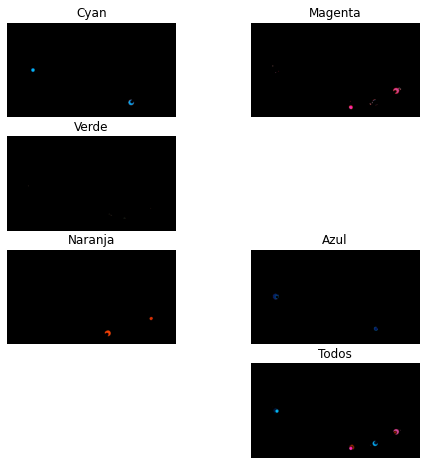

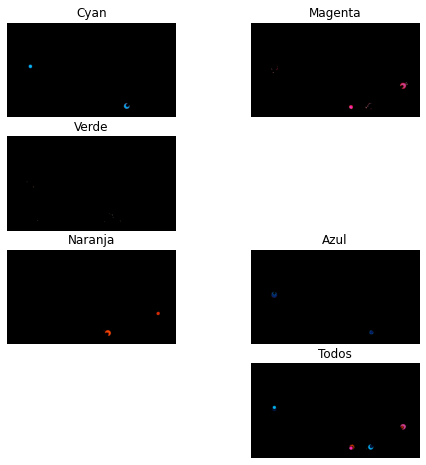

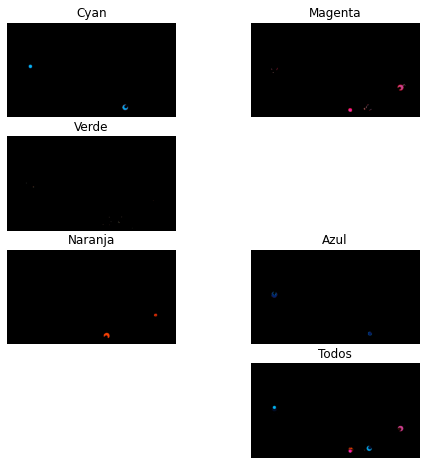

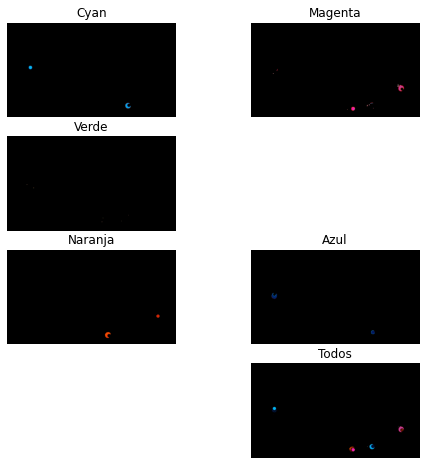

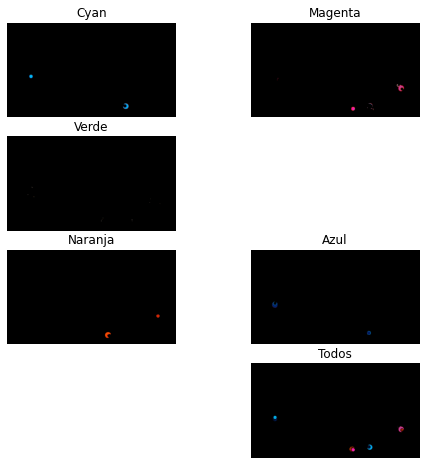

---------LISTA DE ROBOTS DISPONIBLES----------


1. Robot Cyan-Naranja
2. Robot Naranja-Cyan
3. Robot Cyan-Azul
4. Robot Azul-Cyan
5. Robot Magenta-Naranja
6. Robot Naranja-Magenta
7. Robot Naranja-Azul
8. Robot Azul-Naranja
9. Robot Magenta-Azul
10. Robot Azul-Magenta
11. Robot Cyan-Magenta
12. Robot Magenta-Cyan
13. Robot Cyan-Verde
14. Robot Verde-Cyan
15. Robot Magenta-Verde


Ej: 1 8 9 14 15


Indique el número de cada robot que se vaya a usar: 3 4 5 6


Archivo creado


In [9]:
#--------------------- Definición de rangos de color HSV---------------------------
#Rangos cyan:
#light_cyan = (95, 175, 185)
light_cyan = (95, 175, 175)
dark_cyan = (105, 255, 250)

#Rangos magenta:
light_magenta = (145, 50, 150)
dark_magenta = (175, 255, 255)

#Rangos verde:  
light_verde = (30, 50, 50)
dark_verde = (40, 255, 255)

#Rangos rojo:
light_rojo1 = (0, 80, 80)
dark_rojo1 = (3, 255, 240)

light_rojo2 = (175, 70, 50)
dark_rojo2 = (180, 255, 255)

#Rangos azul: 
#light_azul = (100, 125, 10)
light_azul = (100,255,50)
dark_azul = (140,255,200)

#Rangos naranja: 
light_nar = (5, 255, 200)
dark_nar = (25, 255, 255)

#Rangos amarillo: 
#light_ama = (15, 30, 0)
light_ama = (12, 25, 175)
dark_ama = (35, 255, 255)

#Crea un respaldo de todas las imágenes para ser modificadas más adelante
RespaldoImagenes=list(imagenes)

#------------Procesado: aplicar máscara, dilatar, contornos, ubicación -----------------
#Aquí se almacenarán los contornos de cada una de las imágenes
lista_cCyan = []
lista_cMagenta = []
lista_cVerde = []
lista_cNaranja = []
lista_cAzul = []

#Aquí se almacenarán los centros de los contornos
centros_cCyan = []
centros_cMagenta = []
centros_cVerde = []
centros_cNaranja = []
centros_cAzul = []

#Números de color
cyan = 1
magenta = 2
naranja = 3 
verde = 4
azul = 5

for j in range(len(imagenes)):
    
    #Pone 1 en el píxel que está dentro del rango, sino pone 0
    
    #Máscara Cyan
    maskcyan = cv2.inRange(imagenesHSV[j], light_cyan, dark_cyan)
    #Máscara Magenta
    maskmagenta = cv2.inRange(imagenesHSV[j], light_magenta, dark_magenta)
    #Máscara Verde
    maskverde = cv2.inRange(imagenesHSV[j], light_verde, dark_verde)
    #Máscara Azul
    maskazul = cv2.inRange(imagenesHSV[j], light_azul, dark_azul)
    #Máscara Rojo
    masknaranja = cv2.inRange(imagenesHSV[j], light_nar, dark_nar)
    
    #Máscara de todos los colores de identificadores:
    maskAll=masknaranja+maskazul+maskcyan+maskverde+maskmagenta

    #Se utiliza una transformación morfológica de dilatación de la imagen para hacer los
    #contornos más uniformes
    #Se crea el kernel, entre mayor sea más "grosera" es la dilatación
    kernel = np.ones((7,7),np.uint8)
    cyand = cv2.dilate(maskcyan,kernel,iterations=1)
    magentad = cv2.dilate(maskmagenta,kernel,iterations=1)
    verded = cv2.dilate(maskverde,kernel,iterations=1)
    azuld = cv2.dilate(maskazul,kernel,iterations=1)
    naranjad = cv2.dilate(masknaranja,kernel,iterations=1)
    alld = cyand+magentad+verded+azuld+naranjad
    
    #Aplica las máscaras a las imágenes por si se quisieran visualizar
    #"""
    resultcyan = cv2.bitwise_and(imagenes[j], imagenes[j], mask=cyand)
    resultmagenta = cv2.bitwise_and(imagenes[j], imagenes[j], mask=magentad)
    resultverde = cv2.bitwise_and(imagenes[j], imagenes[j], mask=verded)
    resultazul = cv2.bitwise_and(imagenes[j], imagenes[j], mask=azuld)
    resultnaranja = cv2.bitwise_and(imagenes[j], imagenes[j], mask=naranjad)
    #Aplica la máscara combinada
    resultAll = cv2.bitwise_and(imagenes[j], imagenes[j], mask=maskAll)
    
    #Printing results
    
    if ind<5:
        # se crea la figura
        fig = plt.figure(figsize=(8, 8))
        # definición de filas y columnas
        rows = 4
        columns = 2
        
        # Agrega un subplot en la primera posición
        fig.add_subplot(rows, columns, 1)
        # mostrando la imagen
        plt.imshow(resultcyan)
        plt.axis('off')
        plt.title("Cyan")
        title = 'filtrado_cyan'+str(ind)+'.png'
        
        # segunda posición
        fig.add_subplot(rows, columns, 2)
        plt.imshow(resultmagenta)
        plt.axis('off')
        plt.title("Magenta")
        title = 'filtrado_magenta'+str(ind)+'.png'
        
        # tercera posición
        fig.add_subplot(rows, columns, 3)
        plt.imshow(resultverde)
        plt.axis('off')
        plt.title("Verde")
        title = 'filtrado_verde'+str(ind)+'.png'

        # quinta posición
        fig.add_subplot(rows, columns, 5)
        plt.imshow(resultnaranja)
        plt.axis('off')
        plt.title("Naranja")
        title = 'filtrado_naranga'+str(ind)+'.png'
        #cv.imwrite(title, resultnar)
        
        # sexta posición
        fig.add_subplot(rows, columns, 6)
        plt.imshow(resultazul)
        plt.axis('off')
        plt.title("Azul")
        title = 'filtrado_azul'+str(ind)+'.png'
        #cv.imwrite(title, resultazul)
        
        # octava posición
        fig.add_subplot(rows, columns, 8)
        plt.imshow(resultAll)
        plt.axis('off')
        plt.title("Todos")
        plt.show()
    
    ind+=1
     
    #se inicializa la variable de tamaño de contorno
    sizeC=0
    #Busca los contornos en cada una de las imágenes filtradas
    #Se aproximan por medio de una compresión horizontal, vertical y diagonal
    #https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0
    cntsCyan, jerCyan = cv2.findContours(cyand.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cntsMagenta, jerMagenta = cv2.findContours(magentad.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cntsVerde, jerVerde = cv2.findContours(verded.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cntsAzul, jerAzul = cv2.findContours(azuld.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cntsNaranja, jerNaranja = cv2.findContours(naranjad.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #Deja solo los contornos grandes, correspondientes a los círculos pequeños y grandes
    cntsCyans=depurar_contornos(cntsCyan)
    cntsMagentas=depurar_contornos(cntsMagenta)
    cntsVerdes=depurar_contornos(cntsVerde)
    cntsAzules=depurar_contornos(cntsAzul)
    cntsNaranjas=depurar_contornos(cntsNaranja)
    
    #Se ordenan los contornos por área, la "s" al final de la nueva variable es de "sorted"
    #sorted ordena de menor a mayor por área los contornos.
    cntsCyans = sorted(cntsCyans, key=lambda x: cv2.contourArea(x))
    cntsMagentas = sorted(cntsMagentas, key=lambda x: cv2.contourArea(x))
    cntsVerdes = sorted(cntsVerdes, key=lambda x: cv2.contourArea(x))
    cntsAzules = sorted(cntsAzules, key=lambda x: cv2.contourArea(x))
    cntsNaranjas = sorted(cntsNaranjas, key=lambda x: cv2.contourArea(x))
    
    #Se agregan los contornos encontrados por cada color a la lista de contornos correspondiente
    lista_cCyan.append(cntsCyans)
    lista_cMagenta.append(cntsMagentas)
    lista_cVerde.append(cntsVerdes)
    lista_cAzul.append(cntsAzules)
    lista_cNaranja.append(cntsNaranjas)
    
    #Calcula el área de los contornos encontrados
    areasCyan=get_contour_areas(cntsCyans)
    areasMagenta=get_contour_areas(cntsMagentas)
    areasVerde=get_contour_areas(cntsVerdes)
    areasNaranja=get_contour_areas(cntsNaranjas)
    areasAzul=get_contour_areas(cntsAzules)
    
    #Cálculo de los centroides de los contornos
    centrosCyan=centros_contornos(cntsCyans, areasCyan)
    centrosMagenta=centros_contornos(cntsMagentas, areasMagenta)
    centrosVerde=centros_contornos(cntsVerdes, areasVerde)
    centrosAzul=centros_contornos(cntsAzules, areasAzul)
    centrosNaranja=centros_contornos(cntsNaranjas, areasNaranja)
    
    #Agrego los centros de cada color a su respectiva lista que contiene a los
    #centros de todas las imágenes
    #Fueron verificados en paint: validados!
    centros_cCyan.append(centrosCyan)
    centros_cMagenta.append(centrosMagenta)
    centros_cVerde.append(centrosVerde)
    centros_cNaranja.append(centrosNaranja)
    centros_cAzul.append(centrosAzul)
    
#Pregunta al usuario cuales robots se usarán

print("---------LISTA DE ROBOTS DISPONIBLES----------")
print("\n")
print("1. Robot Cyan-Naranja")
print("2. Robot Naranja-Cyan")
print("3. Robot Cyan-Azul")
print("4. Robot Azul-Cyan")
print("5. Robot Magenta-Naranja")
print("6. Robot Naranja-Magenta")
print("7. Robot Naranja-Azul")
print("8. Robot Azul-Naranja")
print("9. Robot Magenta-Azul")
print("10. Robot Azul-Magenta")
print("11. Robot Cyan-Magenta")
print("12. Robot Magenta-Cyan")
print("13. Robot Cyan-Verde")
print("14. Robot Verde-Cyan")
print("15. Robot Magenta-Verde")
print("\n")
print("Ej: 1 8 9 14 15")
print("\n")
lista_usuario = input("Indique el número de cada robot que se vaya a usar: ")    
lista_Robots = lista_usuario.split()
for i in range(len(lista_Robots)):
    lista_Robots[i] = int(lista_Robots[i])
    
#Determina cuál es el robot inicial de la fila india
X_origen, Y_origen = robot_init(lista_Robots, centros_cCyan, centros_cMagenta, centros_cVerde, centros_cNaranja, centros_cAzul)

#Cálculo de desplazamientos
desplazamientosX, posIniciales=calcular_desplazamiento(centros_cCyan, centros_cMagenta, centros_cVerde, centros_cAzul, centros_cNaranja, n, lista_Robots)

#Buscar parejas de cada círculo
#Cada color se identifica con un número: cyan (1), magenta (2), naranja (3), verde (4), azul (5)
#cada combinación se identifica con un número de 0-15 de momento
#el primer color es el círculo grande, y el segundo el pequeño
#Números de Robots:
#cyan-naranja [1], naranja-cyan [2], cyan-azul [3], azul-cyan [4], magenta-naranja [5],
#naranja-magenta [6], naranja-azul [7], azul-naranja [8], magenta-azul [9], azul-magenta [10],
#cyan-magenta [11], magenta-cyan [12], cyan-verde [13], verde-cyan [14], magenta-verde [15]



#Crea archivo txt con los desplazamientos
#Nombre del txt:
#nombretxt="Desplazamientos.txt" 
nombretxt="Tram_CV_140621.txt"
escribir_txt(nombretxt,desplazamientosX, posIniciales)